In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.19.0'

### Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [ ]:
!mkdir data

In [ ]:
!curl https://raw.githubusercontent.com/alan-barzilay/NLPortugues/master/Semana%2003/data/b2w-10k.csv --output 'data/b2w-10k.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3919k  100 3919k    0     0  7429k      0 --:--:-- --:--:-- --:--:-- 7437k


In [ ]:
b2wCorpus = pd.read_csv("data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [ ]:
b2wCorpus["review_text"]

,review_text
0,Estou contente com a compra entrega rápida o ú...
1,"Por apenas R$1994.20,eu consegui comprar esse ..."
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,"A entrega foi no prazo, as americanas estão de..."
...,...
9994,"Celular muito rápido, com processador e armaze..."
9995,"achei o produto muito frágil, o material veio ..."
9996,Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997,"Maquina excelente,super pratica. recomendo.ent..."


### Pré-processamento

Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar.

Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [ ]:
b2wCorpus["reviewer_gender"].value_counts()

,count
reviewer_gender,
M,5033
F,4624
,1
1970,1
Ocorrência: Z-Devolução Em Andamento Ao Cd de São Paulo 22/12/17 16:12,1


_______________________
## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". A coluna "recommend_to_a_friend" vai ser usada para sabermos se **o sentimento foi positivo ou negativo**.

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [ ]:
# Seleciona as colunas relevantes e cria uma cópia
df = b2wCorpus[['review_text', 'recommend_to_a_friend']].copy()

In [ ]:
# Converte 'Yes' -> 1 e 'No' -> 0
df['recommend_to_a_friend'] = df['recommend_to_a_friend'].map({'Yes': 1, 'No': 0})

### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df['review_text']            # Features (texto)
y = df['recommend_to_a_friend']  # Target (0 ou 1)

In [ ]:
# test_size=0.2 significa 20% para teste e 80% para treino
# random_state garante reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## <font color='blue'>Questão 3 </font>
Utilizando a camada `TextVectorization` tokenize os inputs.
Declare a camada e então chame a função `adapt()` para adequar o seu vocabulário aos reviews.

Não se esqueça de se certificar que todas os reviews tenham o mesmo comprimento, seja por meio do uso de padding, truncamento ou uma mistura dos dois. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

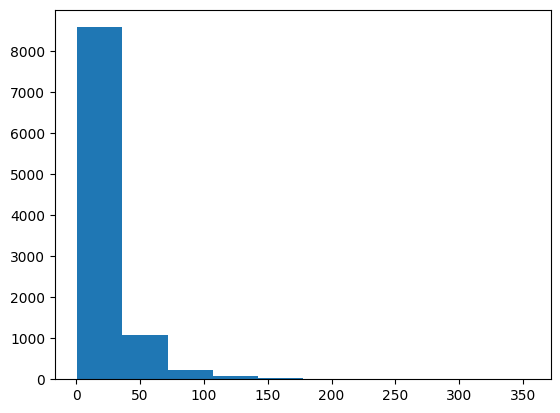

In [ ]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt

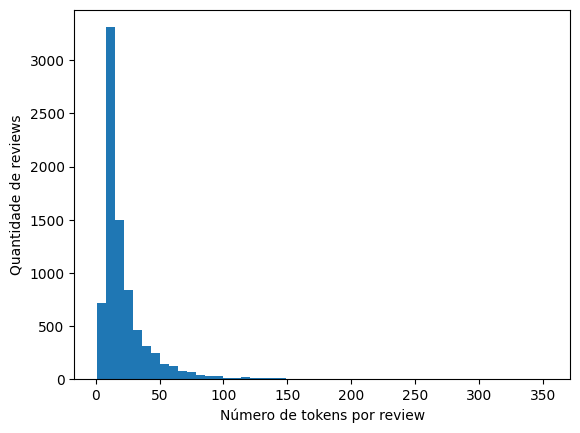

In [ ]:
# Comprimento de cada review em número de palavras
review_lengths = X_train.apply(lambda x: len(str(x).split()))

# Plot do histograma
plt.hist(review_lengths, bins=50)
plt.xlabel("Número de tokens por review")
plt.ylabel("Quantidade de reviews")
plt.show()

In [ ]:
max_tokens = 100  # exemplo, ajuste conforme o histograma
max_vocab_size = 10000  # tamanho máximo do vocabulário

vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',        # retorna inteiros (tokens)
    output_sequence_length=max_tokens  # pad/trunc truncando ou completando
)

In [ ]:
# Treina o vocabulário com os dados de treino
vectorizer.adapt(X_train)

In [ ]:
# Exemplo de tokenização de um review
sample_review = X_train.iloc[0]
vectorized_review = vectorizer(tf.convert_to_tensor([sample_review]))
print(vectorized_review)

tf.Tensor(
[[ 233   16  272   22   18    3   16 2699   16  147    5 5180    6   10
    31    3   28   75  444    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]], shape=(1, 100), dtype=int64)


### Montando o modelo

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

##  <font color='blue'>Questão 4 </font>

Defina seu modelo.

Como analise de sentimentos pode ser visto como um problema de classificação, é interessante também registrar algumas métricas como acurácia `metrics=["acc"]` .

Seu modelo deve começar com a seguinte estrutura:
 - Camada de Input
 - Camada de Tokenização
 - Camada de Embedding

Já definimos as camadas seguintes da rede por você.

Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
max_tokens = 100         # comprimento máximo das sequências (do TextVectorization)
max_vocab_size = 10000   # tamanho do vocabulário
embedding_dim = 128      # dimensão da camada de embedding

In [ ]:
vectorizer = layers.TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_tokens
)

# Adaptar o vocabulário aos dados de treino
vectorizer.adapt(X_train)

In [ ]:
model = tf.keras.Sequential([
    # Camada de Input
    layers.Input(shape=(1,), dtype=tf.string),

    # Camada de tokenização
    vectorizer,

    # Camada de embedding
    layers.Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, mask_zero=True),

    # Camadas convolucionais + global max pooling
    layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3),
    layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3),
    layers.GlobalMaxPooling1D(),

    # Camadas densas
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  # saída binária
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

### Treinando e avaliando seu modelo

##  <font color='blue'>Questão 5 </font>

Com seu modelo definido, treine e avalie sua performance no conjunto de testes.



In [ ]:
import numpy as np

X_train_array = np.array(X_train)
X_test_array  = np.array(X_test)

In [ ]:
# Treina o modelo
history = model.fit(
    X_train_array,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - acc: 0.7770 - loss: 0.5157 - val_acc: 0.8656 - val_loss: 0.3302
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - acc: 0.9364 - loss: 0.1876 - val_acc: 0.8844 - val_loss: 0.3171
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - acc: 0.9803 - loss: 0.0686 - val_acc: 0.8656 - val_loss: 0.4443
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - acc: 0.9932 - loss: 0.0246 - val_acc: 0.8644 - val_loss: 0.6739
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - acc: 0.9973 - loss: 0.0093 - val_acc: 0.8625 - val_loss: 0.7592
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - acc: 0.9981 - loss: 0.0065 - val_acc: 0.8594 - val_loss: 1.0061
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - acc: 0.9993 - loss: 0.0020 - val_acc: 0.8681 - val_loss: 1.1234
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.9987 - loss: 0.0046 - val_acc: 0.8725 - val_loss: 0.9492
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 43m

In [ ]:
test_loss, test_acc = model.evaluate(X_test_array, y_test)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8871 - loss: 0.7460
Acurácia no conjunto de teste: 0.8735


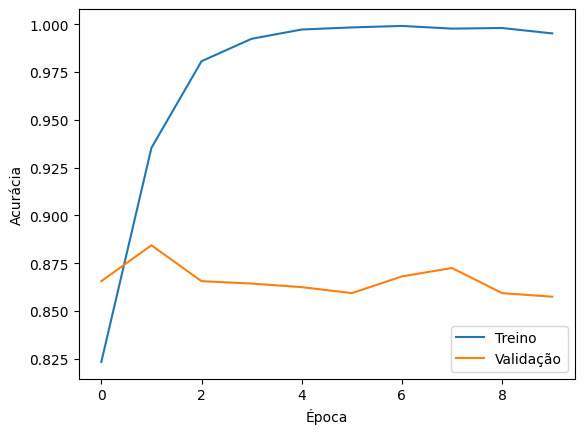

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='Treino')
plt.plot(history.history['val_acc'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()